In [9]:
import pandas as pd
import datetime
from geopy import distance
import numpy as np
from collections import defaultdict
import progressbar
import operator
import random
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt


In [10]:
df=pd.read_pickle('processed_data.pickle')
df_200 = df[:200]

In [11]:
df.head()

,workload,location
0,1507810.0,"(22.522803, 114.218796)"
1,643543.0,"(24.284812, 102.999068)"
2,50378.0,"(25.222206, 117.086322)"
3,3755547.0,"(26.139329, 103.078562)"
4,763464.0,"(26.215115, 109.744661)"


In [12]:
class Species():
    frontier = 0
    distance = 0 
    servers = []
    solution = []
    accessDelay = 0
    workloadBalance = 0
    id = 0 
    def __init__(self,f,d,s,sol,wB,aD, id):
        self.frontier = f
        self.distance = d 
        self.servers = s
        self.solution = sol
        self.accessDelay = aD
        self.workloadBalance = wB
        self.id = id
    def __repr__(self):
        return "Species: " + str(self.id) + " Frontier: " + str(self.frontier) + " distance: " + str(self.distance) + " Access Delay: " + str(self.accessDelay) + " Workload Balance: " + str(self.workloadBalance) + " Servers: " + str(len(self.servers))

In [13]:
def accessDelay(solution, data):
    delay = 0
    i = 0
    for location in solution:
        delay += distance.distance(data.iloc[location]['location'],data.iloc[i]['location']).km
        i+=1
    return delay
def workloadBalance(solution, data):
    servers = dict.fromkeys(solution,0)
    for index,row in data.iterrows():
        servers[solution[index]] +=  row['workload']
    total = 0
    mean = sum(servers.values())/len(servers)
    for key,value in servers.items():
        total += (value - mean)**2
    return np.sqrt(total/len(servers))

In [14]:
def naive_solution(data,servers):
    solution = []
    for j in range(0,len(data)):
        best_server = 0
        min_dist = np.inf
        for server in servers:
            dist = distance.distance(data.iloc[j]['location'],data.iloc[server]['location']).km
            if dist < min_dist:
                best_server = server
                min_dist = dist
        solution.append(best_server)
    return solution

def init_pop(data, server_count = 20, pop_size = 100, server_variance = 5):
    pop = {}
    progress = progressbar.ProgressBar()
    for i in progress(range(pop_size)):
        if server_variance:
            server_n = np.random.randint(server_count-server_variance, server_count + server_variance)
        else:
            server_n = server_count
        servers = list(np.random.choice(range(len(data)),server_n,False)) #list of server_n random servers
        solution = naive_solution(data,servers)
        pop[i] = Species(0,0,servers,solution, workloadBalance(solution,data), accessDelay(solution,data),"Gen 0, Species:" + str(i))
    return pop


In [15]:
data = df[:30]
servers = list(np.random.choice(range(len(data)),5,False))
solution = naive_solution(data,servers)
accessDelay(solution, data)

10417.01342196208

In [17]:
solution

[16,
 16,
 16,
 16,
 16,
 14,
 16,
 14,
 16,
 16,
 16,
 16,
 17,
 24,
 14,
 24,
 16,
 17,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 29,
 16,
 29]

In [18]:
init_pop(data, pop_size = 10)

100% |########################################################################|


{0: Species: Gen 0, Species:0 Frontier: 0 distance: 0 Access Delay: 1941.6783708033706 Workload Balance: 1080913.300914601 Servers: 18,
 1: Species: Gen 0, Species:1 Frontier: 0 distance: 0 Access Delay: 328.67576538894946 Workload Balance: 1107001.7282729014 Servers: 19,
 2: Species: Gen 0, Species:2 Frontier: 0 distance: 0 Access Delay: 2353.8863534390634 Workload Balance: 1464032.4920624692 Servers: 17,
 3: Species: Gen 0, Species:3 Frontier: 0 distance: 0 Access Delay: 210.08701509344905 Workload Balance: 1146286.5937911451 Servers: 24,
 4: Species: Gen 0, Species:4 Frontier: 0 distance: 0 Access Delay: 1333.1858503733479 Workload Balance: 944161.159794536 Servers: 23,
 5: Species: Gen 0, Species:5 Frontier: 0 distance: 0 Access Delay: 172.5438780814179 Workload Balance: 1004741.2371023973 Servers: 24,
 6: Species: Gen 0, Species:6 Frontier: 0 distance: 0 Access Delay: 2269.6346698849293 Workload Balance: 1115668.056265101 Servers: 19,
 7: Species: Gen 0, Species:7 Frontier: 0 dist

In [6]:
def checkDominance(a,b, check_servers = False):
    if check_servers:
        if a.accessDelay < b.accessDelay and a.workloadBalance <= b.workloadBalance and len(a.servers) <= len(b.servers):
            return True
        if a.accessDelay <= b.accessDelay and a.workloadBalance < b.workloadBalance and len(a.servers) <= len(b.servers):
            return True
        if a.accessDelay <= b.accessDelay and a.workloadBalance <= b.workloadBalance and len(a.servers) < len(b.servers):
            return True
    else:
        if a.accessDelay < b.accessDelay and a.workloadBalance <= b.workloadBalance:
            return True
        if a.accessDelay <= b.accessDelay and a.workloadBalance < b.workloadBalance:
            return True
    return False

def nonDominatedSort(population, check_servers = False):
    S = {}
    n = {}
    F = defaultdict(list)
    for key in population.keys():
        S[key] = []
        n[key] = 0
        for key2 in population.keys():
            if key == key2:
                pass
            elif checkDominance(population[key],population[key2], check_servers):
                S[key].append(key2)
            elif checkDominance(population[key2],population[key], check_servers):
                n[key] += 1
        if n[key] == 0:
            population[key].frontier = 0  #set rank of species internally 
            F[0].append(key)
    i = 0
    while F[i] != []:
        Q = []
        for p in F[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    population[q].frontier = i + 1 #set rank of species internally 
                    Q.append(q)
        i = i + 1
        if not Q:
            break
        F[i] = Q
    return F

In [7]:
def crowdingDistance(population, check_servers = False):
    #set distances to 0 
    for member in population:
        member.distance = 0

    #sort by access delay and compute distances and set distance internally
    population = sorted(population, key = lambda x: x.accessDelay)
    population[0].distance = -np.inf
    population[-1].distance = -np.inf
    for i in range(1,len(population)-1):
        population[i].distance = population[i].distance - (population[i+1].accessDelay - population[i-1].accessDelay)/(population[-1].accessDelay - population[0].accessDelay)
    
    #sort by workload balance and compute distances and set distance internally
    population = sorted(population, key = lambda x: x.workloadBalance)
    population[0].distance = -np.inf
    population[-1].distance = -np.inf
    for i in range(1,len(population)-1):
        population[i].distance = population[i].distance - (population[i+1].workloadBalance - population[i-1].workloadBalance)/(population[-1].workloadBalance - population[0].workloadBalance)
    
    if check_servers:
        #sort by num servers and compute distances and set distance internally
        population = sorted(population, key = lambda x: len(x.servers))
        population[0].distance = -np.inf
        population[-1].distance = -np.inf
        for i in range(1,len(population)-1):
            population[i].distance = population[i].distance - (len(population[i+1].servers) - len(population[i-1].servers))/(len(population[-1].servers) - len(population[0].servers))


In [8]:
def roulette(choices):
    choice_odds = [] 
    #get odds for each choice
    for i in range(len(choices)):
        choice_odds.append((2*(len(choices) - i))/(len(choices)*(len(choices)+1)))

    #pick a choice
    max = sum([x for x in choice_odds])
    pick = np.random.uniform(0, max)
    current = 0
    selected_choice = 0
    for x in choice_odds:
        current += x
        if current >= pick:
            break
        selected_choice += 1
    return selected_choice

def selection(population, frontiers):
    #pick a frontier
    selected_frontier = roulette(frontiers)
    #get distances for each member of frontier
    distances = []
    for i in frontiers[selected_frontier]:
        distances.append((population[i].distance,i))
    distances = sorted(distances)

    #pick a specific member
    selection = roulette(distances)
    try:
        selected_member = distances[selection]
    except Exception:
        print(selection)
        print(distances)
    selected_member = selected_member[1]
    return population[selected_member]


In [9]:

def mutate(data, species, fixed_servers):
    #to start available mutations will be one server is randomly changed
    if fixed_servers:
        server = np.random.choice(species.servers)
        new_server = np.random.randint(0,len(species.solution))
        species.servers = list(species.servers)
        species.servers.append(new_server)
        species.servers.remove(server)
        species.solution = naive_solution(data,species.servers)
        species.accessDelay = accessDelay(species.solution,data)
        species.workloadBalance = workloadBalance(species.solution, data) 

def breed(data,a,b,gen,id,fixed_servers):
    if fixed_servers:
        server_count = len(a.servers)
        new_servers = set(a.servers) | set(b.servers)
        try:
            new_servers = np.random.choice(list(new_servers), server_count, False)
        except Exception:
            print(a.servers)
            print(b.servers)
            print(new_servers)
        new_solution = []
        set_new_servers = set(new_servers)
        for i in range(len(a.solution)):
            if a.solution[i] in set_new_servers:
                new_solution.append(a.solution[i])
            elif b.solution[i] in set_new_servers:
                new_solution.append(b.solution[i])
            else:
                best_server = 0
                min_dist = np.inf
                for server in new_servers:
                    dist = distance.distance(data.iloc[i]['location'],data.iloc[server]['location']).km
                    if dist < min_dist:
                        best_server = server
                        min_dist = dist
                new_solution.append(best_server)
        return Species(0,0,new_servers,new_solution, workloadBalance(new_solution,data), accessDelay(new_solution,data), "Gen " + str(gen) + ", Species:" + str(id))

def new_generation(data,population,gen, mutation_rate, fixed_servers):       
    pop_list = sorted(population.values(), key = operator.attrgetter("frontier", "distance"))
    next_gen = {}
    i = 1
    frontiers = nonDominatedSort(population)
    for i in tqdm_notebook(range(len(population)),leave=False, desc='Next Generation'): 
        a = selection(population,frontiers)
        b = selection(population,frontiers)
        new_species = breed(data,a,b,gen,i,fixed_servers)
        n = np.random.random(1)[0]
        if n < mutation_rate:
            mutate(data, new_species, fixed_servers)
        next_gen[new_species.id] = new_species
    return next_gen

In [10]:
access_delay_averages = []
workload_balance_averages = []
access_delay_mins = []
workload_balance_mins = []
def evolution(data,generations = 20, pop_size = 150, server_count = 20, fixed_servers = True):
    population = init_pop(df_200,pop_size=pop_size, server_count =server_count,server_variance = 0)
    for i in tqdm_notebook(range(generations), desc='Generation'):
        gen = {}
        frontiers = nonDominatedSort(population)
        crowdingDistance(list(population.values()))
        pop_list = sorted(population.values(), key = operator.attrgetter("frontier", "distance"))
        print(pop_list)
        population = {}
        for k in range(0,pop_size):
            id = pop_list[k].id
            population[id] = pop_list[k]

        if i%1 == 0:
            print("Generation: " + str(i))
            ads = []
            wbs = []
            for key,value in population.items():
                ads.append(value.accessDelay)
                wbs.append(value.workloadBalance)
            plt.xlabel("Access Delay")
            plt.ylabel("Workload Balance")
            plt.scatter(ads,wbs)
            plt.show()
            average_ad = sum(ads)/len(ads)
            average_wb = sum(wbs)/len(wbs)
            access_delay_averages.append(average_ad)
            workload_balance_averages.append(average_wb)
            access_delay_mins.append(min(ads))
            workload_balance_mins.append(min(wbs))
            print("Average access delay:" + str(average_ad))
            print("Average workload balance:" + str(average_wb))
            print("Minimum access delay:" + str(min(ads)))
            print("Minimum workload balance:" + str(min(wbs)))

        
        next_gen = new_generation(data,population, i+1, .1, fixed_servers)
        population.update(next_gen)
    gen = {}
    frontiers = nonDominatedSort(population)
    j = 0
    while len(gen) < pop_size:
        front = [population[x] for x in frontiers[j]]
        crowdingDistance(front)
        gen.update({key: value for key, value in population.items() if key in frontiers[j]})
        j += 1
    population = gen
    return frontiers,population
   
        

100% |########################################################################|
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32256\3014957559.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(generations), desc='Generation'):


Generation:   0%|          | 0/20 [00:00<?, ?it/s]

[Species: Gen 0, Species:82 Frontier: 0 distance: -inf Access Delay: 2029.4401099987654 Workload Balance: 4586292.964341059 Servers: 20, Species: Gen 0, Species:125 Frontier: 0 distance: -inf Access Delay: 6257.295788509693 Workload Balance: 2313521.851163827 Servers: 20, Species: Gen 0, Species:145 Frontier: 0 distance: -0.3836398117546028 Access Delay: 3694.864308598668 Workload Balance: 4015849.284122127 Servers: 20, Species: Gen 0, Species:76 Frontier: 0 distance: -0.048255154505046326 Access Delay: 3848.3973354477753 Workload Balance: 2437118.042280308 Servers: 20, Species: Gen 0, Species:15 Frontier: 0 distance: -0.024476618225063522 Access Delay: 4234.816603632753 Workload Balance: 2388158.1153698764 Servers: 20, Species: Gen 0, Species:129 Frontier: 0 distance: -0.023098619259144654 Access Delay: 6122.794344640099 Workload Balance: 2364777.149207426 Servers: 20, Species: Gen 0, Species:48 Frontier: 0 distance: -0.009528366946686809 Access Delay: 3785.6400425470406 Workload Bala

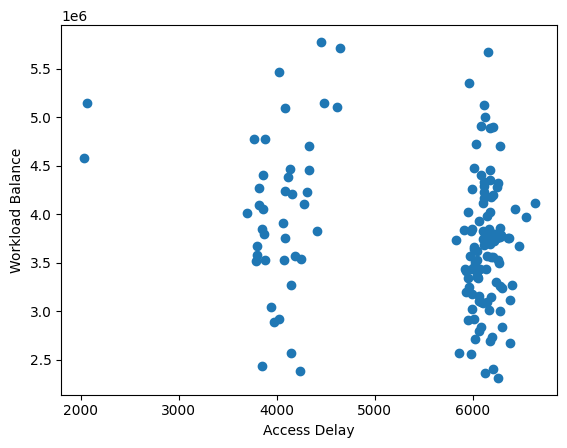

Average Access Delay:5533.725078428414
Average Workload Balance:3770486.430642311
Minimum Access Delay:2029.4401099987654
Minimum Workload Balance:2313521.851163827


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32256\4269542047.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(population)),leave=False, desc='Next Generation'):


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 0, Species:82 Frontier: 0 distance: -inf Access Delay: 2029.4401099987654 Workload Balance: 4586292.964341059 Servers: 20, Species: Gen 1, Species:125 Frontier: 0 distance: -inf Access Delay: 6312.871126388375 Workload Balance: 2266261.926390747 Servers: 20, Species: Gen 1, Species:27 Frontier: 0 distance: -0.29862972481942507 Access Delay: 3327.447947115843 Workload Balance: 3302776.7305613016 Servers: 20, Species: Gen 1, Species:74 Frontier: 0 distance: -0.05291879853837044 Access Delay: 2083.836968229256 Workload Balance: 4261571.413201086 Servers: 20, Species: Gen 0, Species:76 Frontier: 0 distance: -0.028040548182755705 Access Delay: 3848.3973354477753 Workload Balance: 2437118.042280308 Servers: 20, Species: Gen 0, Species:125 Frontier: 0 distance: -0.013291465382310205 Access Delay: 6257.295788509693 Workload Balance: 2313521.851163827 Servers: 20, Species: Gen 0, Species:129 Frontier: 0 distance: -0.01163239623934908 Access Delay: 6122.794344640099 Workload Balanc

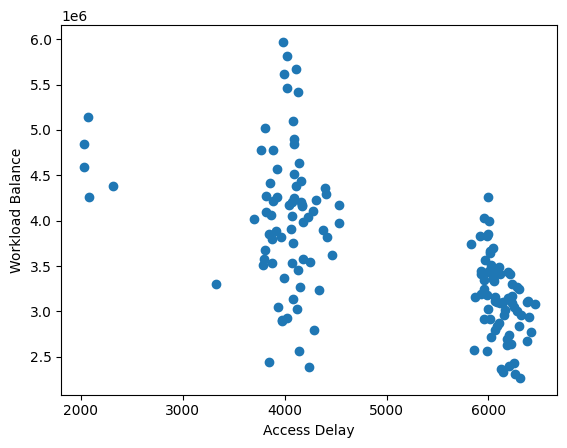

Average Access Delay:5021.114603850668
Average Workload Balance:3610702.9498658627
Minimum Access Delay:2029.4401099987654
Minimum Workload Balance:2266261.926390747


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 0, Species:82 Frontier: 0 distance: -inf Access Delay: 2029.4401099987654 Workload Balance: 4586292.964341059 Servers: 20, Species: Gen 1, Species:125 Frontier: 0 distance: -inf Access Delay: 6312.871126388375 Workload Balance: 2266261.926390747 Servers: 20, Species: Gen 2, Species:108 Frontier: 0 distance: -0.02922740047940568 Access Delay: 2194.2523595915077 Workload Balance: 3326763.282057448 Servers: 20, Species: Gen 2, Species:53 Frontier: 0 distance: -0.016762524176208906 Access Delay: 2047.8485632063591 Workload Balance: 4135717.192079362 Servers: 20, Species: Gen 0, Species:129 Frontier: 0 distance: -0.013669453438927457 Access Delay: 6122.794344640099 Workload Balance: 2364777.149207426 Servers: 20, Species: Gen 0, Species:76 Frontier: 0 distance: -0.012700393462026375 Access Delay: 3848.3973354477753 Workload Balance: 2437118.042280308 Servers: 20, Species: Gen 1, Species:19 Frontier: 0 distance: -0.01212308548979417 Access Delay: 6146.855295287256 Workload Bala

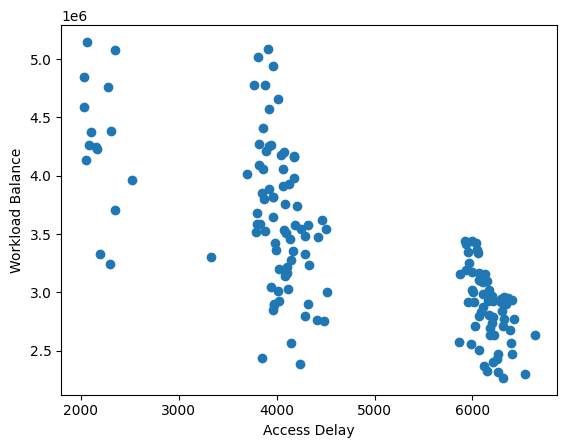

Average Access Delay:4748.891969647652
Average Workload Balance:3382476.9239130397
Minimum Access Delay:2029.4401099987654
Minimum Workload Balance:2266261.926390747


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 1, Species:125 Frontier: 0 distance: -inf Access Delay: 6312.871126388375 Workload Balance: 2266261.926390747 Servers: 20, Species: Gen 3, Species:100 Frontier: 0 distance: -inf Access Delay: 1948.8364632928367 Workload Balance: 5005019.451846776 Servers: 20, Species: Gen 0, Species:82 Frontier: 0 distance: -0.02302628808431558 Access Delay: 2029.4401099987654 Workload Balance: 4586292.964341059 Servers: 20, Species: Gen 3, Species:85 Frontier: 0 distance: -0.020328000737528332 Access Delay: 3759.944086675355 Workload Balance: 3133230.344131295 Servers: 20, Species: Gen 3, Species:147 Frontier: 0 distance: -0.017936418933145234 Access Delay: 2141.1698863640695 Workload Balance: 4034777.752423243 Servers: 20, Species: Gen 0, Species:76 Frontier: 0 distance: -0.015256066294665875 Access Delay: 3848.3973354477753 Workload Balance: 2437118.042280308 Servers: 20, Species: Gen 2, Species:53 Frontier: 0 distance: -0.01208735260339423 Access Delay: 2047.8485632063591 Workload Bal

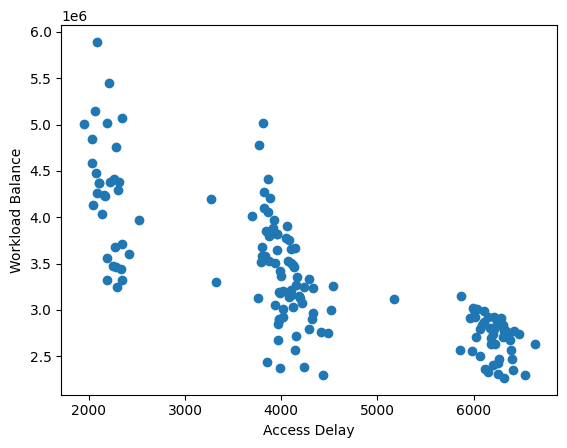

Average Access Delay:4314.82742209888
Average Workload Balance:3357667.65903171
Minimum Access Delay:1948.8364632928367
Minimum Workload Balance:2266261.926390747


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 4, Species:73 Frontier: 0 distance: -inf Access Delay: 1874.8995490884524 Workload Balance: 3740127.5653322674 Servers: 20, Species: Gen 4, Species:101 Frontier: 0 distance: -inf Access Delay: 6309.7474594145315 Workload Balance: 2119624.6562031624 Servers: 20, Species: Gen 4, Species:129 Frontier: 0 distance: -0.14889294832559272 Access Delay: 5378.596875728195 Workload Balance: 2191320.900077987 Servers: 20, Species: Gen 4, Species:139 Frontier: 0 distance: -0.1377569060587158 Access Delay: 3195.469804596344 Workload Balance: 2664543.754524853 Servers: 20, Species: Gen 3, Species:102 Frontier: 0 distance: -0.010459254099066718 Access Delay: 4438.048501950013 Workload Balance: 2301039.994590483 Servers: 20, Species: Gen 4, Species:148 Frontier: 0 distance: -0.005320471866176472 Access Delay: 3773.67613496322 Workload Balance: 2381141.1972123575 Servers: 20, Species: Gen 4, Species:53 Frontier: 0 distance: -0.004576878035401645 Access Delay: 2308.806595108106 Workload Bal

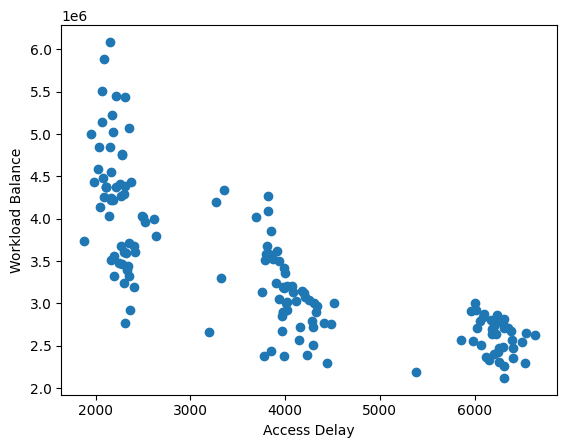

Average Access Delay:3901.343205601923
Average Workload Balance:3410777.090554614
Minimum Access Delay:1874.8995490884524
Minimum Workload Balance:2119624.6562031624


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 4, Species:73 Frontier: 0 distance: -inf Access Delay: 1874.8995490884524 Workload Balance: 3740127.5653322674 Servers: 20, Species: Gen 4, Species:101 Frontier: 0 distance: -inf Access Delay: 6309.7474594145315 Workload Balance: 2119624.6562031624 Servers: 20, Species: Gen 4, Species:139 Frontier: 0 distance: -0.09177896990242902 Access Delay: 3195.469804596344 Workload Balance: 2664543.754524853 Servers: 20, Species: Gen 4, Species:129 Frontier: 0 distance: -0.048768890984825404 Access Delay: 5378.596875728195 Workload Balance: 2191320.900077987 Servers: 20, Species: Gen 4, Species:148 Frontier: 0 distance: -0.008014230186310724 Access Delay: 3773.67613496322 Workload Balance: 2381141.1972123575 Servers: 20, Species: Gen 2, Species:108 Frontier: 0 distance: -0.007968533513447201 Access Delay: 2194.2523595915077 Workload Balance: 3326763.282057448 Servers: 20, Species: Gen 3, Species:102 Frontier: 0 distance: -0.007202661721095564 Access Delay: 4438.048501950013 Workload

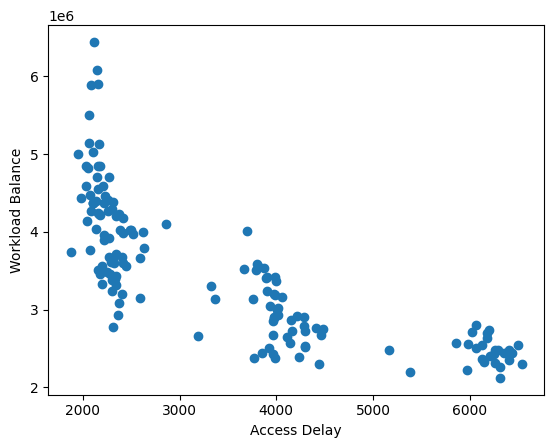

Average Access Delay:3487.3731227904223
Average Workload Balance:3478991.8169471174
Minimum Access Delay:1874.8995490884524
Minimum Workload Balance:2119624.6562031624


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[43, 53, 13, 16, 31, 103, 66, 76, 187, 168, 151, 199, 129, 28, 67, 78, 147, 119, 194, 119]
[43, 53, 13, 16, 31, 103, 66, 76, 187, 168, 151, 199, 129, 28, 67, 78, 147, 119, 194, 119]
{129, 13, 16, 147, 151, 28, 31, 168, 43, 53, 187, 66, 67, 194, 199, 76, 78, 103, 119}
[Species: Gen 4, Species:73 Frontier: 0 distance: -inf Access Delay: 1874.8995490884524 Workload Balance: 3740127.5653322674 Servers: 20, Species: Gen 6, Species:114 Frontier: 0 distance: -inf Access Delay: 6251.195631504208 Workload Balance: 2092726.4920003999 Servers: 20, Species: Gen 6, Species:135 Frontier: 0 distance: -0.02031287753905047 Access Delay: 1993.3489140189065 Workload Balance: 2155681.6127256593 Servers: 20, Species: Gen 6, Species:52 Frontier: 1 distance: -0.10680487044359407 Access Delay: 5506.8388763963885 Workload Balance: 2188252.238196275 Servers: 20, Species: Gen 4, Species:129 Frontier: 1 distance: -0.04305874959063726 Access Delay: 5378.596875728195 Workload Balance: 2191320.900077987 Servers: 20,

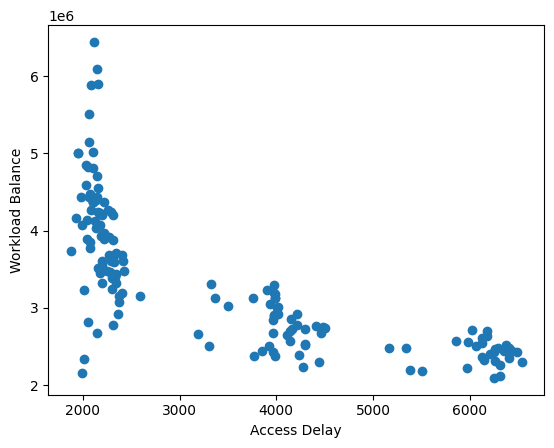

Average Access Delay:3478.0261378544897
Average Workload Balance:3351678.7706802855
Minimum Access Delay:1874.8995490884524
Minimum Workload Balance:2092726.4920003999


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 4, Species:73 Frontier: 0 distance: -inf Access Delay: 1874.8995490884524 Workload Balance: 3740127.5653322674 Servers: 20, Species: Gen 6, Species:114 Frontier: 0 distance: -inf Access Delay: 6251.195631504208 Workload Balance: 2092726.4920003999 Servers: 20, Species: Gen 6, Species:135 Frontier: 0 distance: -0.020393498951211616 Access Delay: 1993.3489140189065 Workload Balance: 2155681.6127256593 Servers: 20, Species: Gen 7, Species:89 Frontier: 0 distance: -0.016433830829549703 Access Delay: 1874.8995490884524 Workload Balance: 3740127.5653322674 Servers: 20, Species: Gen 7, Species:72 Frontier: 0 distance: -0.012877116205366045 Access Delay: 1962.2367578160465 Workload Balance: 2998617.381831183 Servers: 20, Species: Gen 7, Species:30 Frontier: 0 distance: -0.012504210803247413 Access Delay: 1928.1494977623277 Workload Balance: 3512843.836651154 Servers: 20, Species: Gen 7, Species:111 Frontier: 0 distance: -0.00758607805832775 Access Delay: 6061.708338689149 Workloa

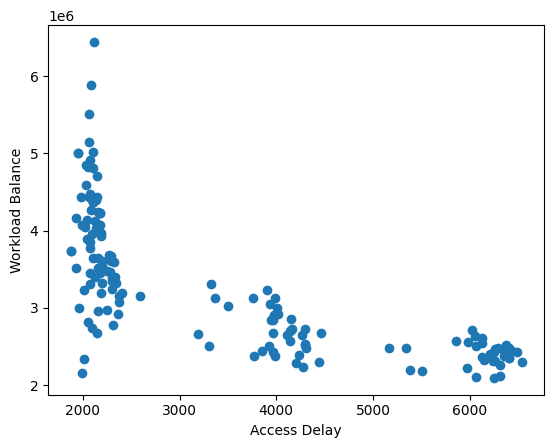

Average Access Delay:3500.4089686006523
Average Workload Balance:3250181.8581701256
Minimum Access Delay:1874.8995490884524
Minimum Workload Balance:2092726.4920003999


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 8, Species:108 Frontier: 0 distance: -inf Access Delay: 4430.191415831533 Workload Balance: 2051530.0279650604 Servers: 20, Species: Gen 8, Species:113 Frontier: 0 distance: -inf Access Delay: 1284.1690250924905 Workload Balance: 5042911.5288459305 Servers: 20, Species: Gen 4, Species:73 Frontier: 0 distance: -0.10861072845730958 Access Delay: 1874.8995490884524 Workload Balance: 3740127.5653322674 Servers: 20, Species: Gen 6, Species:135 Frontier: 0 distance: -0.01842823811463318 Access Delay: 1993.3489140189065 Workload Balance: 2155681.6127256593 Servers: 20, Species: Gen 7, Species:72 Frontier: 0 distance: -0.0093474897635809 Access Delay: 1962.2367578160465 Workload Balance: 2998617.381831183 Servers: 20, Species: Gen 8, Species:53 Frontier: 0 distance: -0.009069127487514324 Access Delay: 1881.3741093952563 Workload Balance: 3660708.3873597337 Servers: 20, Species: Gen 7, Species:89 Frontier: 0 distance: -0.007641325315618017 Access Delay: 1874.8995490884524 Workload

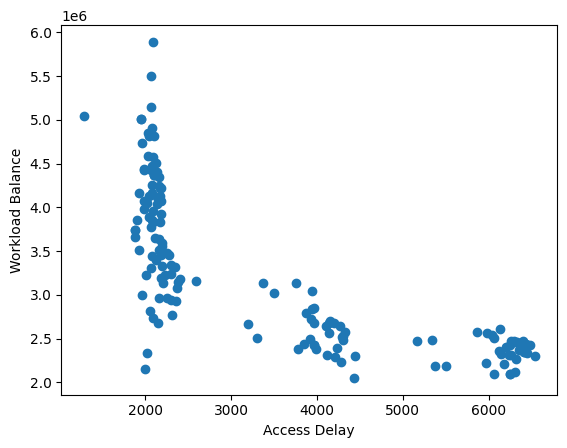

Average Access Delay:3439.0473724417834
Average Workload Balance:3237713.93952432
Minimum Access Delay:1284.1690250924905
Minimum Workload Balance:2051530.0279650604


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 8, Species:108 Frontier: 0 distance: -inf Access Delay: 4430.191415831533 Workload Balance: 2051530.0279650604 Servers: 20, Species: Gen 8, Species:113 Frontier: 0 distance: -inf Access Delay: 1284.1690250924905 Workload Balance: 5042911.5288459305 Servers: 20, Species: Gen 4, Species:73 Frontier: 0 distance: -0.08515953249877119 Access Delay: 1874.8995490884524 Workload Balance: 3740127.5653322674 Servers: 20, Species: Gen 6, Species:135 Frontier: 0 distance: -0.02121012671968567 Access Delay: 1993.3489140189065 Workload Balance: 2155681.6127256593 Servers: 20, Species: Gen 9, Species:75 Frontier: 0 distance: -0.012952504133150253 Access Delay: 1914.391961505683 Workload Balance: 3255153.501937167 Servers: 20, Species: Gen 7, Species:72 Frontier: 0 distance: -0.009746716595030175 Access Delay: 1962.2367578160465 Workload Balance: 2998617.381831183 Servers: 20, Species: Gen 8, Species:53 Frontier: 0 distance: -0.008713479635030174 Access Delay: 1881.3741093952563 Workload

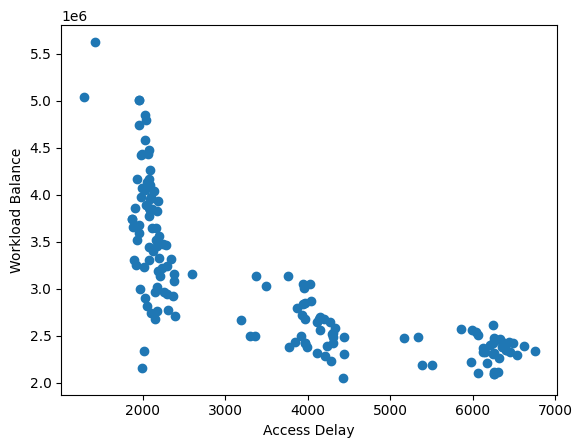

Average Access Delay:3562.0612744432383
Average Workload Balance:3071404.2951627225
Minimum Access Delay:1284.1690250924905
Minimum Workload Balance:2051530.0279650604


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 8, Species:113 Frontier: 0 distance: -inf Access Delay: 1284.1690250924905 Workload Balance: 5042911.5288459305 Servers: 20, Species: Gen 10, Species:103 Frontier: 0 distance: -inf Access Delay: 4654.106880092818 Workload Balance: 1989957.800253951 Servers: 20, Species: Gen 4, Species:73 Frontier: 0 distance: -0.04137311354853673 Access Delay: 1874.8995490884524 Workload Balance: 3740127.5653322674 Servers: 20, Species: Gen 10, Species:135 Frontier: 0 distance: -0.028473357700756013 Access Delay: 1379.2829405084674 Workload Balance: 4059263.1526245554 Servers: 20, Species: Gen 8, Species:108 Frontier: 0 distance: -0.026355741717244294 Access Delay: 4430.191415831533 Workload Balance: 2051530.0279650604 Servers: 20, Species: Gen 6, Species:135 Frontier: 0 distance: -0.01957374390833301 Access Delay: 1993.3489140189065 Workload Balance: 2155681.6127256593 Servers: 20, Species: Gen 8, Species:53 Frontier: 0 distance: -0.008768380858738167 Access Delay: 1881.3741093952563 Wor

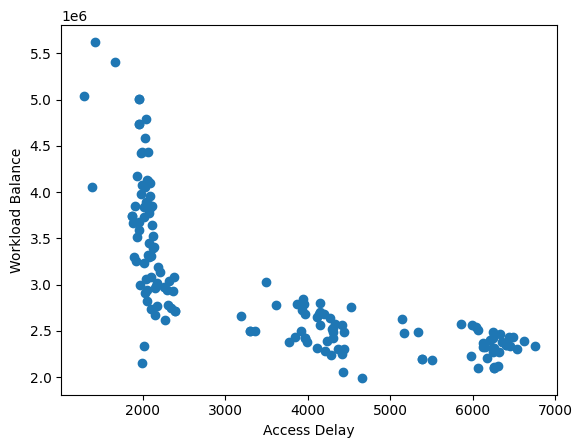

Average Access Delay:3598.611766598363
Average Workload Balance:2992424.4746274226
Minimum Access Delay:1284.1690250924905
Minimum Workload Balance:1989957.800253951


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[122, 157, 18, 183, 185, 117, 71, 48, 67, 115, 126, 196, 33, 118, 165, 187, 189, 65, 70, 65]
[122, 157, 18, 183, 185, 117, 71, 48, 67, 115, 126, 196, 33, 118, 165, 187, 189, 65, 70, 65]
{18, 157, 33, 165, 48, 183, 185, 187, 189, 65, 67, 196, 70, 71, 115, 117, 118, 122, 126}
[Species: Gen 8, Species:113 Frontier: 0 distance: -inf Access Delay: 1284.1690250924905 Workload Balance: 5042911.5288459305 Servers: 20, Species: Gen 10, Species:103 Frontier: 0 distance: -inf Access Delay: 4654.106880092818 Workload Balance: 1989957.800253951 Servers: 20, Species: Gen 11, Species:136 Frontier: 0 distance: -0.034703398887000976 Access Delay: 1551.3310724251096 Workload Balance: 3314689.1685616095 Servers: 20, Species: Gen 11, Species:84 Frontier: 0 distance: -0.029615020612231577 Access Delay: 1344.6973893056215 Workload Balance: 4364436.268504124 Servers: 20, Species: Gen 8, Species:108 Frontier: 0 distance: -0.026955041786289467 Access Delay: 4430.191415831533 Workload Balance: 2051530.027965060

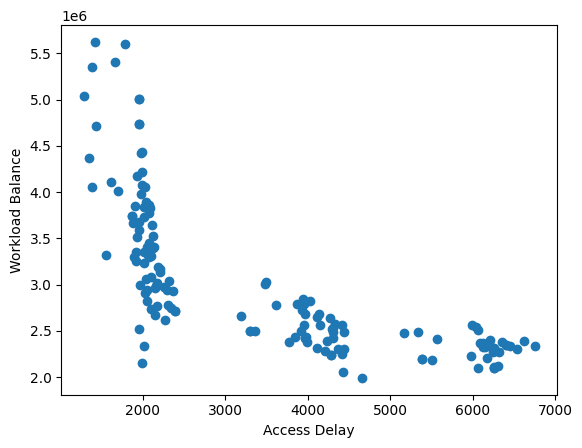

Average Access Delay:3436.252957714231
Average Workload Balance:3018248.1451397627
Minimum Access Delay:1284.1690250924905
Minimum Workload Balance:1989957.800253951


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 10, Species:103 Frontier: 0 distance: -inf Access Delay: 4654.106880092818 Workload Balance: 1989957.800253951 Servers: 20, Species: Gen 12, Species:69 Frontier: 0 distance: -inf Access Delay: 1207.4251234635278 Workload Balance: 3672857.2142320303 Servers: 20, Species: Gen 12, Species:43 Frontier: 0 distance: -0.02713084330333708 Access Delay: 1527.079503453821 Workload Balance: 3482321.1533700754 Servers: 20, Species: Gen 8, Species:108 Frontier: 0 distance: -0.022913443455449836 Access Delay: 4430.191415831533 Workload Balance: 2051530.0279650604 Servers: 20, Species: Gen 11, Species:136 Frontier: 0 distance: -0.01608496313679969 Access Delay: 1551.3310724251096 Workload Balance: 3314689.1685616095 Servers: 20, Species: Gen 12, Species:22 Frontier: 0 distance: -0.013030321031738538 Access Delay: 4654.106880092818 Workload Balance: 1989957.800253951 Servers: 20, Species: Gen 12, Species:131 Frontier: 0 distance: -0.010533807163235022 Access Delay: 1660.0639579206763 Wor

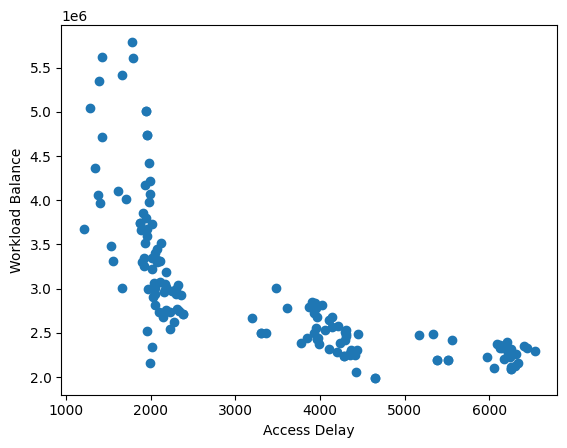

Average Access Delay:3375.9087530380702
Average Workload Balance:2983864.6671394855
Minimum Access Delay:1207.4251234635278
Minimum Workload Balance:1989957.800253951


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 10, Species:103 Frontier: 0 distance: -inf Access Delay: 4654.106880092818 Workload Balance: 1989957.800253951 Servers: 20, Species: Gen 12, Species:69 Frontier: 0 distance: -inf Access Delay: 1207.4251234635278 Workload Balance: 3672857.2142320303 Servers: 20, Species: Gen 8, Species:108 Frontier: 0 distance: -0.024957149252606153 Access Delay: 4430.191415831533 Workload Balance: 2051530.0279650604 Servers: 20, Species: Gen 13, Species:55 Frontier: 0 distance: -0.018016147724974146 Access Delay: 4654.106880092818 Workload Balance: 1989957.800253951 Servers: 20, Species: Gen 13, Species:66 Frontier: 0 distance: -0.013176274295510689 Access Delay: 1266.5132939523864 Workload Balance: 3414756.1678371415 Servers: 20, Species: Gen 6, Species:135 Frontier: 0 distance: -0.008853118186747725 Access Delay: 1993.3489140189065 Workload Balance: 2155681.6127256593 Servers: 20, Species: Gen 11, Species:113 Frontier: 0 distance: -0.005224108709392118 Access Delay: 1955.8371093218766 W

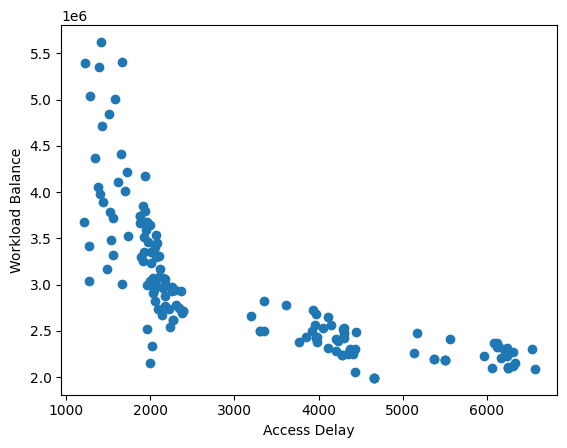

Average Access Delay:3217.171903277234
Average Workload Balance:2948337.8156293086
Minimum Access Delay:1207.4251234635278
Minimum Workload Balance:1989957.800253951


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 12, Species:69 Frontier: 0 distance: -inf Access Delay: 1207.4251234635278 Workload Balance: 3672857.2142320303 Servers: 20, Species: Gen 14, Species:96 Frontier: 0 distance: -inf Access Delay: 4578.5153010944705 Workload Balance: 1964519.3244820877 Servers: 20, Species: Gen 8, Species:108 Frontier: 0 distance: -0.024824640383731146 Access Delay: 4430.191415831533 Workload Balance: 2051530.0279650604 Servers: 20, Species: Gen 14, Species:144 Frontier: 0 distance: -0.013981622018671362 Access Delay: 1448.629139171451 Workload Balance: 2857416.4170072936 Servers: 20, Species: Gen 14, Species:37 Frontier: 0 distance: -0.010186195898410633 Access Delay: 1258.8273336667633 Workload Balance: 3484107.2956947954 Servers: 20, Species: Gen 6, Species:135 Frontier: 0 distance: -0.008232627399715508 Access Delay: 1993.3489140189065 Workload Balance: 2155681.6127256593 Servers: 20, Species: Gen 13, Species:66 Frontier: 0 distance: -0.007532106556274377 Access Delay: 1266.5132939523864

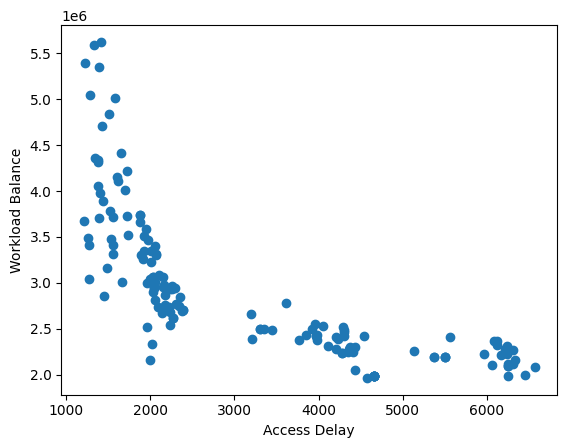

Average Access Delay:3193.807338202627
Average Workload Balance:2919102.0904082893
Minimum Access Delay:1207.4251234635278
Minimum Workload Balance:1964519.3244820877


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 12, Species:69 Frontier: 0 distance: -inf Access Delay: 1207.4251234635278 Workload Balance: 3672857.2142320303 Servers: 20, Species: Gen 14, Species:96 Frontier: 0 distance: -inf Access Delay: 4578.5153010944705 Workload Balance: 1964519.3244820877 Servers: 20, Species: Gen 8, Species:108 Frontier: 0 distance: -0.027679645375010827 Access Delay: 4430.191415831533 Workload Balance: 2051530.0279650604 Servers: 20, Species: Gen 14, Species:37 Frontier: 0 distance: -0.013789891765609978 Access Delay: 1258.8273336667633 Workload Balance: 3484107.2956947954 Servers: 20, Species: Gen 13, Species:83 Frontier: 0 distance: -0.012372462665175199 Access Delay: 1275.2659405877398 Workload Balance: 3037777.5206741733 Servers: 20, Species: Gen 14, Species:144 Frontier: 0 distance: -0.010455911599205028 Access Delay: 1448.629139171451 Workload Balance: 2857416.4170072936 Servers: 20, Species: Gen 13, Species:66 Frontier: 0 distance: -0.008577539126296363 Access Delay: 1266.5132939523864

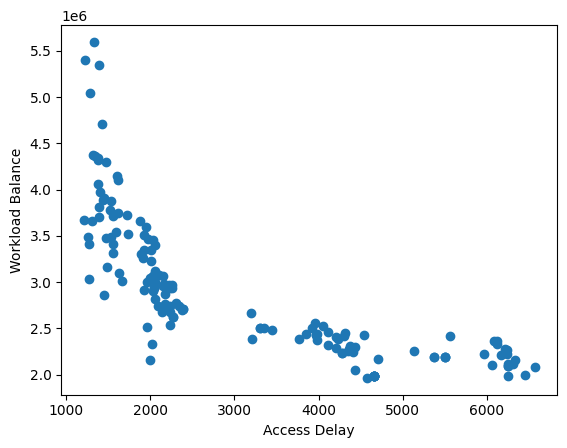

Average Access Delay:3108.346487270397
Average Workload Balance:2900690.5612815297
Minimum Access Delay:1207.4251234635278
Minimum Workload Balance:1964519.3244820877


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 14, Species:96 Frontier: 0 distance: -inf Access Delay: 4578.5153010944705 Workload Balance: 1964519.3244820877 Servers: 20, Species: Gen 16, Species:82 Frontier: 0 distance: -inf Access Delay: 1155.725076195258 Workload Balance: 3605258.223712124 Servers: 20, Species: Gen 8, Species:108 Frontier: 0 distance: -0.014301506771996306 Access Delay: 4430.191415831533 Workload Balance: 2051530.0279650604 Servers: 20, Species: Gen 16, Species:145 Frontier: 0 distance: -0.009187271503056229 Access Delay: 4430.191415831533 Workload Balance: 2051530.0279650604 Servers: 20, Species: Gen 14, Species:37 Frontier: 0 distance: -0.008677504097313866 Access Delay: 1258.8273336667633 Workload Balance: 3484107.2956947954 Servers: 20, Species: Gen 11, Species:113 Frontier: 0 distance: -0.0057552301689095375 Access Delay: 1955.8371093218766 Workload Balance: 2519514.1294000316 Servers: 20, Species: Gen 6, Species:135 Frontier: 0 distance: -0.00572555793631058 Access Delay: 1993.3489140189065 

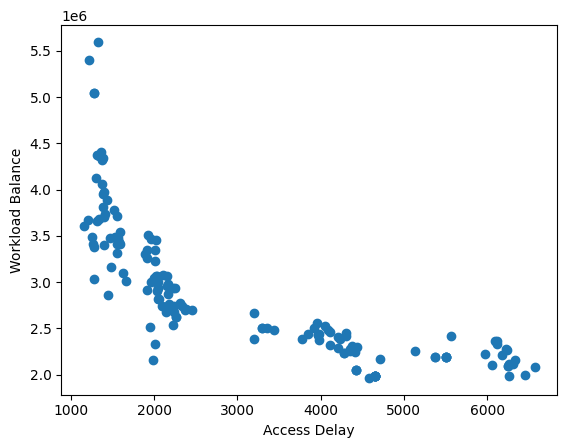

Average Access Delay:3112.3199766497683
Average Workload Balance:2862008.4818966147
Minimum Access Delay:1155.725076195258
Minimum Workload Balance:1964519.3244820877


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 14, Species:96 Frontier: 0 distance: -inf Access Delay: 4578.5153010944705 Workload Balance: 1964519.3244820877 Servers: 20, Species: Gen 16, Species:82 Frontier: 0 distance: -inf Access Delay: 1155.725076195258 Workload Balance: 3605258.223712124 Servers: 20, Species: Gen 8, Species:108 Frontier: 0 distance: -0.01512075731281688 Access Delay: 4430.191415831533 Workload Balance: 2051530.0279650604 Servers: 20, Species: Gen 11, Species:113 Frontier: 0 distance: -0.011857283453820866 Access Delay: 1955.8371093218766 Workload Balance: 2519514.1294000316 Servers: 20, Species: Gen 13, Species:83 Frontier: 0 distance: -0.010779972283942311 Access Delay: 1275.2659405877398 Workload Balance: 3037777.5206741733 Servers: 20, Species: Gen 6, Species:135 Frontier: 0 distance: -0.008880725138471667 Access Delay: 1993.3489140189065 Workload Balance: 2155681.6127256593 Servers: 20, Species: Gen 16, Species:35 Frontier: 0 distance: -0.008734363144140889 Access Delay: 4430.191415831533 Wo

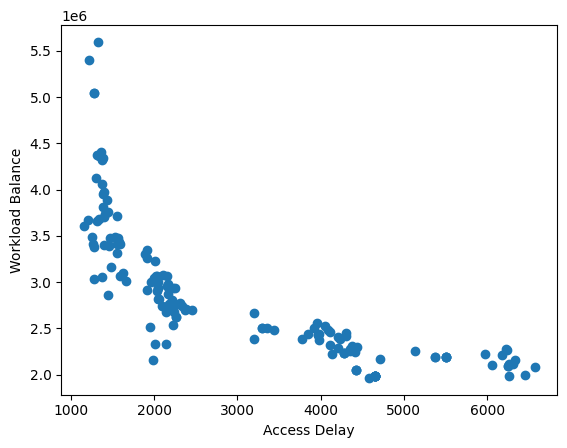

Average Access Delay:3049.1109358281155
Average Workload Balance:2843486.273346846
Minimum Access Delay:1155.725076195258
Minimum Workload Balance:1964519.3244820877


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 14, Species:96 Frontier: 0 distance: -inf Access Delay: 4578.5153010944705 Workload Balance: 1964519.3244820877 Servers: 20, Species: Gen 16, Species:82 Frontier: 0 distance: -inf Access Delay: 1155.725076195258 Workload Balance: 3605258.223712124 Servers: 20, Species: Gen 8, Species:108 Frontier: 0 distance: -0.015197563927388155 Access Delay: 4430.191415831533 Workload Balance: 2051530.0279650604 Servers: 20, Species: Gen 14, Species:37 Frontier: 0 distance: -0.011557208815419707 Access Delay: 1258.8273336667633 Workload Balance: 3484107.2956947954 Servers: 20, Species: Gen 6, Species:135 Frontier: 0 distance: -0.009538941588813752 Access Delay: 1993.3489140189065 Workload Balance: 2155681.6127256593 Servers: 20, Species: Gen 18, Species:42 Frontier: 0 distance: -0.009524865994808923 Access Delay: 4430.191415831533 Workload Balance: 2051530.0279650604 Servers: 20, Species: Gen 11, Species:113 Frontier: 0 distance: -0.008154507072614932 Access Delay: 1955.8371093218766 W

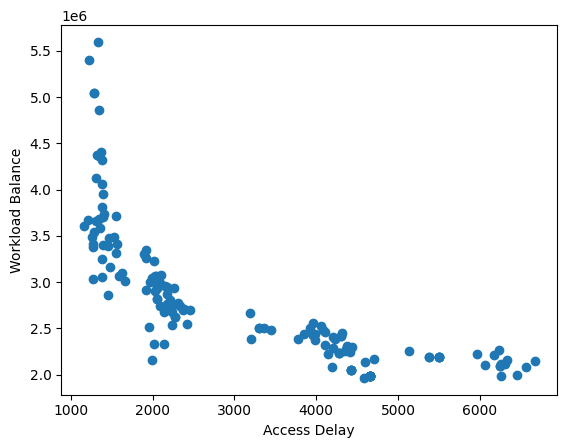

Average Access Delay:3121.6356183735325
Average Workload Balance:2803783.4895607643
Minimum Access Delay:1155.725076195258
Minimum Workload Balance:1964519.3244820877


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

[Species: Gen 14, Species:96 Frontier: 0 distance: -inf Access Delay: 4578.5153010944705 Workload Balance: 1964519.3244820877 Servers: 20, Species: Gen 19, Species:131 Frontier: 0 distance: -inf Access Delay: 1135.5827081872208 Workload Balance: 3877602.4495757297 Servers: 20, Species: Gen 19, Species:55 Frontier: 0 distance: -0.02012746962738268 Access Delay: 1155.725076195258 Workload Balance: 3605258.223712124 Servers: 20, Species: Gen 8, Species:108 Frontier: 0 distance: -0.01416943183462266 Access Delay: 4430.191415831533 Workload Balance: 2051530.0279650604 Servers: 20, Species: Gen 11, Species:113 Frontier: 0 distance: -0.011367201124871773 Access Delay: 1955.8371093218766 Workload Balance: 2519514.1294000316 Servers: 20, Species: Gen 14, Species:144 Frontier: 0 distance: -0.01039971386783765 Access Delay: 1448.629139171451 Workload Balance: 2857416.4170072936 Servers: 20, Species: Gen 16, Species:145 Frontier: 0 distance: -0.00901931695869393 Access Delay: 4430.191415831533 Wor

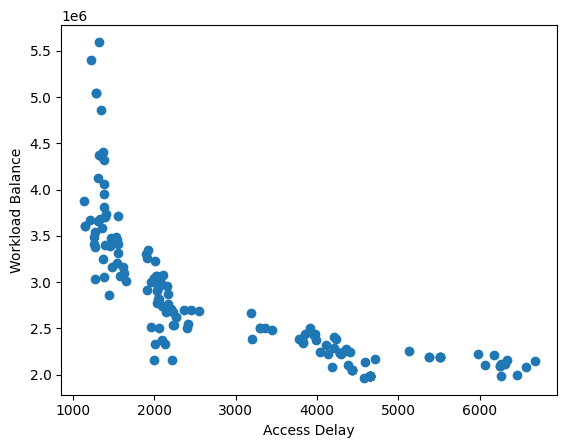

Average Access Delay:3007.366141017862
Average Workload Balance:2818924.751332198
Minimum Access Delay:1135.5827081872208
Minimum Workload Balance:1964519.3244820877


Next Generation:   0%|          | 0/150 [00:00<?, ?it/s]

In [11]:
frontiers,population = evolution(df_200,pop_size=150)

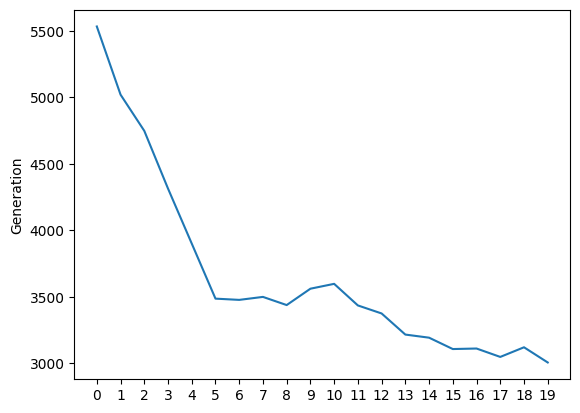

In [12]:
plt.xlabel("Access delay average")
plt.ylabel("Generation")
plt.xticks(range(0,20))
plt.plot(access_delay_averages)

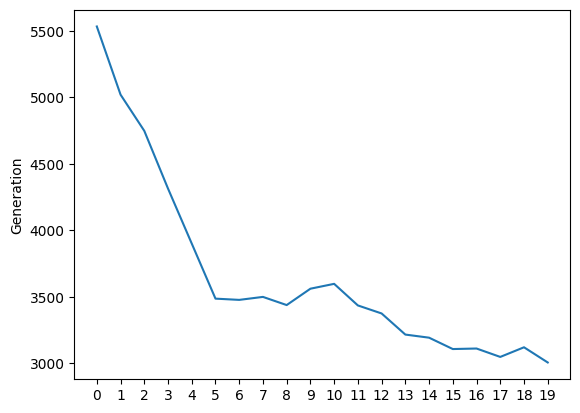

In [13]:
plt.xlabel("Workload balance average")
plt.ylabel("Generation")
plt.xticks(range(0,20))
plt.plot(workload_balance_averages)

In [14]:
import pickle

In [15]:
file = open("results.pickle","wb")
pickle.dump(population, file)

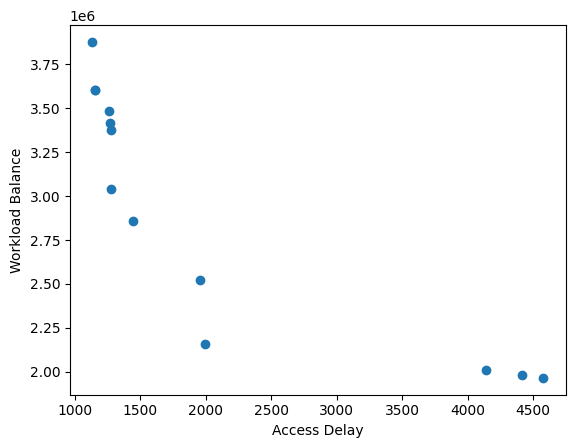

Average Access Delay:2080.8010252740914
Average Workload Balance:2914520.4067937406
Minimum Access Delay:1135.5827081872208
Minimum Workload Balance:1964519.3244820877


In [17]:
frontiers = nonDominatedSort(population)
front1 = {key:value for key,value in population.items() if value.id in frontiers[0]}
ads = []
wbs = []
for key,value in front1.items():
    ads.append(value.accessDelay)
    wbs.append(value.workloadBalance)
plt.xlabel("Access Delay")
plt.ylabel("Workload Balance")
plt.scatter(ads,wbs)
plt.show()
average_ad = sum(ads)/len(ads)
average_wb = sum(wbs)/len(wbs)
access_delay_averages.append(average_ad)
workload_balance_averages.append(average_wb)
access_delay_mins.append(min(ads))
workload_balance_mins.append(min(wbs))
print("Average access delay:" + str(average_ad))
print("Average workload balance:" + str(average_wb))
print("Minimum access delay:" + str(min(ads)))
print("Minimum workload balance:" + str(min(wbs)))